In [ ]:
!pip install livelossplot --quiet

In [ ]:
import os
import torch
import torchvision
import tarfile
import livelossplot
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split, DataLoader

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [ ]:
## Set seed
seed = 1211
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [ ]:
# Dowload the dataset
dataset_url = "http://files.fast.ai/data/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [ ]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test', 'labels.txt']
['bird', 'frog', 'automobile', 'deer', 'dog', 'ship', 'horse', 'airplane', 'cat', 'truck']


In [ ]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['5702_airplane.png', '6085_airplane.png', '23106_airplane.png', '42722_airplane.png', '4787_airplane.png']


In [ ]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of test examples for ship: 1000
['8294_ship.png', '9274_ship.png', '3273_ship.png', '8644_ship.png', '7559_ship.png']


In [ ]:
## Load Data and create pytorch dataset
train_ds = ImageFolder(data_dir+'/train', transform=ToTensor())
test_ds = ImageFolder(data_dir+'/test', transform=ToTensor())

In [ ]:
## Classes and its indxes 
print(train_ds.classes)
print("Index :", train_ds.class_to_idx)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Index : {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [ ]:
def show_example(img, label):
    print('Label: ', train_ds.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  airplane (0)


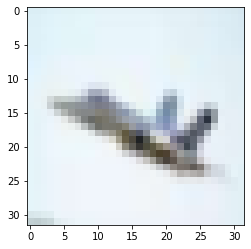

In [ ]:
show_example(*train_ds[0])

Label:  airplane (0)


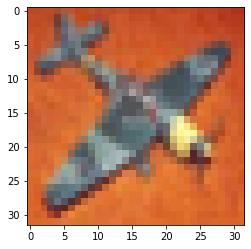

In [ ]:
show_example(*train_ds[199])

In [ ]:
## Lets create validation set
val_size = 5000
train_size = len(train_ds) - val_size
train_size, val_size

(45000, 5000)

In [ ]:
train_ds, val_ds = random_split(train_ds, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [ ]:
class Cifar10CnnModel(nn.Module):
    def __init__(self):
        super(Cifar10CnnModel,self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(512, 10))
        
    def forward(self, inputs):
        return self.network(inputs)

In [ ]:
def save_model(model_path, model_name, model, optimizer, logs, epoch):
    model_dict = {
        "model": model.state_dict(),
        "optimizer":optimizer.state_dict(),
        "logs":logs,
        "epoch":epoch
    }
    
    os.makedirs(model_path, exist_ok=True)
    model_file_path = os.path.join(model_path,model_name)
    torch.save(model_dict,model_file_path)

def evaluate(model, inputs):
    
    model.eval()
    outputs = model(inputs.float())
    
    preds = F.softmax(outputs)
    preds = torch.argmax(preds, axis=1)
    return preds

def accuracy(preds, labels):
    acc = (torch.sum(preds==labels).item()/len(labels))*100
    return np.round(acc,3)

In [ ]:
def train(model, dataloaders, loss_fn, optimizer, num_epochs, model_name):
    
    lossplot = livelossplot.PlotLosses()
    min_loss = 9999999
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ["train","validation"]:
            
            running_loss = 0.0
            running_accuracy = 0
            
            if phase == "train":
                model.train()
            else:
                model.eval()
                
            for inputs, labels in dataloaders[phase]:
                # inputs.to(device)
                # labels.to(device)
                outputs = model(inputs.float())
                loss = loss_fn(outputs, labels)
                
                running_loss += loss.item()
                
                preds = torch.argmax(outputs,axis=1)
                running_accuracy += torch.sum(preds==labels)
                
                
                if phase=="train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
            prefix = ''
            if phase=="validation":
                prefix ="val_"
            
            print("")
            epoch_loss = running_loss/len(dataloaders[phase])
            epoch_acc = running_accuracy.item()/len(dataloaders[phase].dataset)
                
            logs[prefix+'loss'] = np.round(epoch_loss,3)
            logs[prefix+'accuracy'] = np.round(epoch_acc,3)
            
            if phase == "validation":
                if epoch_loss<min_loss:
                    min_loss = epoch_loss
                    save_model('./model',model_name ,model, optimizer,logs, epoch)
        
        lossplot.update(logs)
        lossplot.send()

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dataset = dl.dataset
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

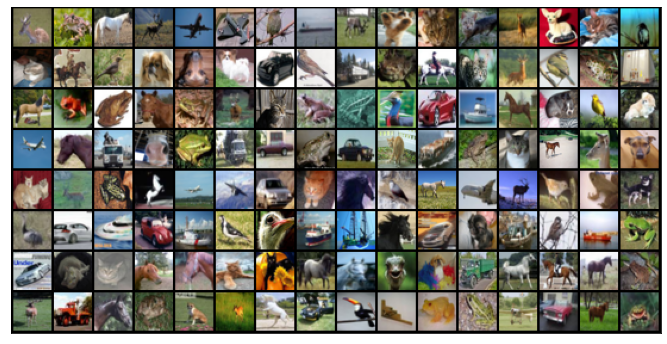

In [ ]:
### Create Model Config
batch_size = 128
learning_rate = 0.001
epochs = 10
model_name = 'cnn_model.pth'

## Create dataloader 
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True) 
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_dl)

In [ ]:
device = get_default_device()
print("Device :", device)


model = Cifar10CnnModel()
to_device(model, device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)


dataloaders = {
    "train": train_dl,
    "validation" : val_dl
}

Device : cuda


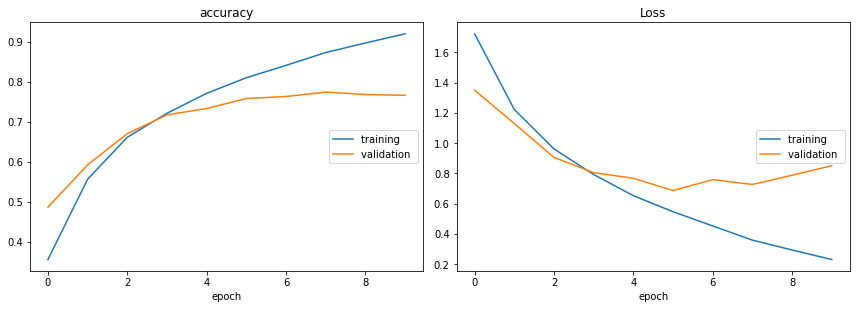

accuracy
	training         	 (min:    0.355, max:    0.920, cur:    0.920)
	validation       	 (min:    0.486, max:    0.774, cur:    0.766)
Loss
	training         	 (min:    0.230, max:    1.722, cur:    0.230)
	validation       	 (min:    0.686, max:    1.349, cur:    0.850)


In [ ]:
train(model , dataloaders, loss_fn, optimizer, epochs, model_name)

In [ ]:
del train_ds, train_dl, val_dl, val_ds

In [ ]:
## Load model
model_file_path = './model/cnn_model.pth'
model_dict = torch.load(model_file_path)

model = Cifar10CnnModel()
model.load_state_dict(model_dict['model'])

<All keys matched successfully>

In [ ]:
model.eval()
to_device(model,device)
running_accuracy = 0
for inputs, labels in test_dl:
  outputs = model(inputs.float())
  preds = torch.argmax(outputs,axis=1)
  running_accuracy += torch.sum(preds==labels)

acc = running_accuracy.item()/len(test_dl.dataset)
print("Test Accuracy :", acc)

Test Accuracy : 0.7565
